In [132]:
import pandas as pd
import matplotlib.pyplot as plt

In [133]:
races = pd.read_csv("./dataset/races.csv")
circuits = pd.read_csv("./dataset/circuits.csv")
constructors = pd.read_csv("./dataset/constructors.csv")
drivers = pd.read_csv("./dataset/drivers.csv")
driver_standings = pd.read_csv("./dataset/driver_standings.csv")
demonyms = pd.read_csv("./dataset/demonyms.csv")

In [134]:
# Alfonso Thiele had an American-Italian citizenship, but he mainly raced for an italian team
alfonso_index = drivers[(drivers['forename'] == 'Alfonso') & (drivers['surname'] == 'Thiele')].index
alessandro_index = drivers[(drivers['forename'] == 'Alessandro') & (drivers['surname'] == 'de Tomaso')].index

drivers.loc[alfonso_index, 'nationality'] = 'Italian'
drivers.loc[alessandro_index, 'nationality'] = 'Italian'

# There are multiple east german drivers
drivers[drivers['nationality'] == 'East German'] = 'German'

In [135]:
def lookup_country(nationality: str) -> str:
    match = demonyms[demonyms['nationality'] == nationality].iloc[0]['country']
    return match

display(drivers['nationality'])
drivers['country'] = drivers['nationality'].apply(lookup_country)

0         British
1          German
2          German
3         Spanish
4         Finnish
          ...    
852        German
853       Chinese
854         Dutch
855    Australian
856      American
Name: nationality, Length: 857, dtype: object

In [136]:
races.rename(columns={'name':'race_name'}, inplace=True)
races.drop(columns='url', inplace=True)

circuits.rename(columns={'name':'circuit_name'}, inplace=True)
circuits.drop(columns='url', inplace=True)

races_circuits = pd.merge(races, circuits, on='circuitId', how='left', )

display(races_circuits)

,raceId,year,round,circuitId,race_name,date,time,fp1_date,fp1_time,fp2_date,...,quali_time,sprint_date,sprint_time,circuitRef,circuit_name,location,country,lat,lng,alt
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,\N,\N,\N,...,\N,\N,\N,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,\N,\N,\N,...,\N,\N,\N,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,\N,\N,\N,...,\N,\N,\N,shanghai,Shanghai International Circuit,Shanghai,China,31.33890,121.22000,5
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,\N,\N,\N,...,\N,\N,\N,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,\N,\N,\N,...,\N,\N,\N,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,1116,2023,19,69,United States Grand Prix,2023-10-22,19:00:00,2023-10-20,17:30:00,2023-10-21,...,21:00:00,2023-10-21,22:00:00,americas,Circuit of the Americas,Austin,USA,30.13280,-97.64110,161
1098,1117,2023,20,32,Mexico City Grand Prix,2023-10-29,20:00:00,2023-10-27,18:30:00,2023-10-27,...,21:00:00,\N,\N,rodriguez,Autódromo Hermanos Rodríguez,Mexico City,Mexico,19.40420,-99.09070,2227
1099,1118,2023,21,18,São Paulo Grand Prix,2023-11-05,17:00:00,2023-11-03,14:30:00,2023-11-04,...,18:00:00,2023-11-04,18:30:00,interlagos,Autódromo José Carlos Pace,São Paulo,Brazil,-23.70360,-46.69970,785
1100,1119,2023,22,80,Las Vegas Grand Prix,2023-11-19,06:00:00,2023-11-17,04:30:00,2023-11-17,...,08:00:00,\N,\N,vegas,Las Vegas Strip Street Circuit,Las Vegas,United States,36.11470,-115.17300,\N


In [137]:
drivers = drivers[['driverId', 'country']]
driver_standings = driver_standings[['raceId', 'driverId', 'position', 'points']]
races = races[['raceId', 'circuitId', 'year']]
circuits = circuits[['circuitId', 'country']]

# join the dataframes
driver_results = pd.merge(drivers, driver_standings, on='driverId')
driver_race_results = pd.merge(driver_results, races, on='raceId')
driver_circuit_results = pd.merge(driver_race_results, circuits, on='circuitId')

display(driver_circuit_results)

home_results = driver_circuit_results['country_x'] == driver_circuit_results['country_y']
home_drivers = driver_circuit_results[home_results]
away_drivers = driver_circuit_results[~home_results]

,driverId,country_x,raceId,position,points,circuitId,year,country_y
0,1,United Kingdom,18,1,10.0,1,2008,Australia
1,2,Germany,18,2,8.0,1,2008,Australia
2,3,Germany,18,3,6.0,1,2008,Australia
3,4,Spain,18,4,5.0,1,2008,Australia
4,5,Finland,18,5,4.0,1,2008,Australia
...,...,...,...,...,...,...,...,...
33882,725,United Kingdom,825,17,0.0,66,1951,Switzerland
33883,741,France,825,10,0.0,66,1951,Switzerland
33884,763,Italy,825,4,3.0,66,1951,Switzerland
33885,764,France,825,14,0.0,66,1951,Switzerland


/tmp/ipykernel_332642/2505851620.py:9: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Home', 'Away')


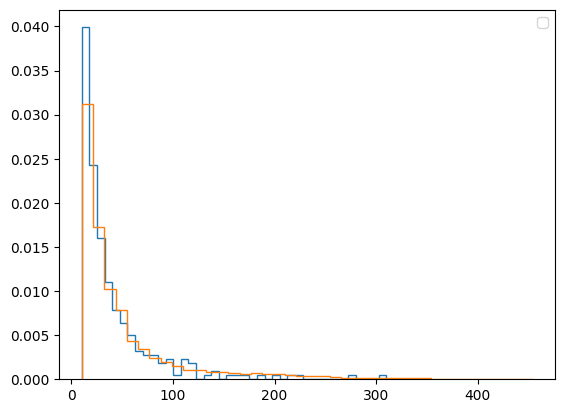

In [176]:
points_home = home_drivers['points']
points_away = away_drivers['points']

points_home = points_home[points_home > 10]
points_away = points_away[points_away > 10]

plt.hist(points_home, bins=40, density=True, histtype='step')
plt.hist(points_away, bins=40, density=True, histtype='step')
plt.show()
plt.legend('Home', 'Away')